In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import plot_confusion_matrix,classification_report,f1_score,roc_curve,precision_score,recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score,confusion_matrix, roc_auc_score
from keras.layers import concatenate

In [2]:
import ipynb
from ipynb.fs.full. LSTM_global import lstm_global
# Hyperparameter optimization
#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
raw_dataset = tf.data.TFRecordDataset(r'TESS_lightcurves/train-00000-of-00008')
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

# Any random 3 tic(TESS Input Catalog- used to identify target star)

In [5]:
def plot_tce_tess(tess_sample):
    global_view_sample = np.array(tess_sample.features.feature["global_view"].float_list.value)
    local_view_sample = np.array(tess_sample.features.feature["local_view"].float_list.value)
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(global_view_sample, ".")
    ax[1].plot(local_view_sample, ".", label=str(tess_sample.features.feature['Disposition'])+' '+str(tess_sample.features.feature['Sectors']))
    plt.legend(loc='upper right', fontsize=15)
    #plt.savefig(save_dir + str(tess_sample['tic_id']) + '_' + str(tess_sample['Sectors']) + '.png', bbox_inches='tight')
    #plt.close('all')

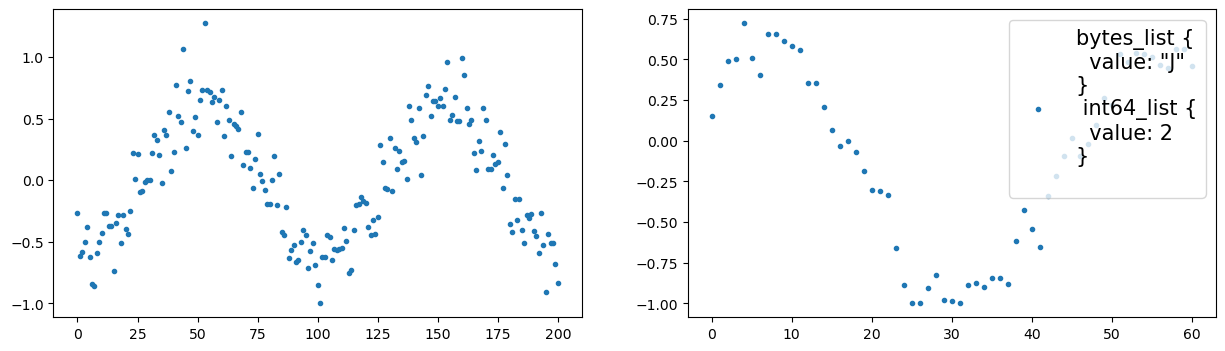

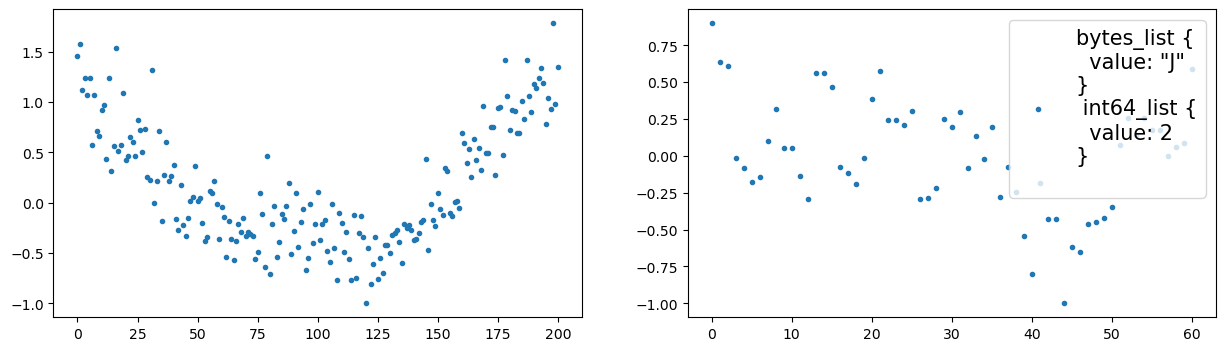

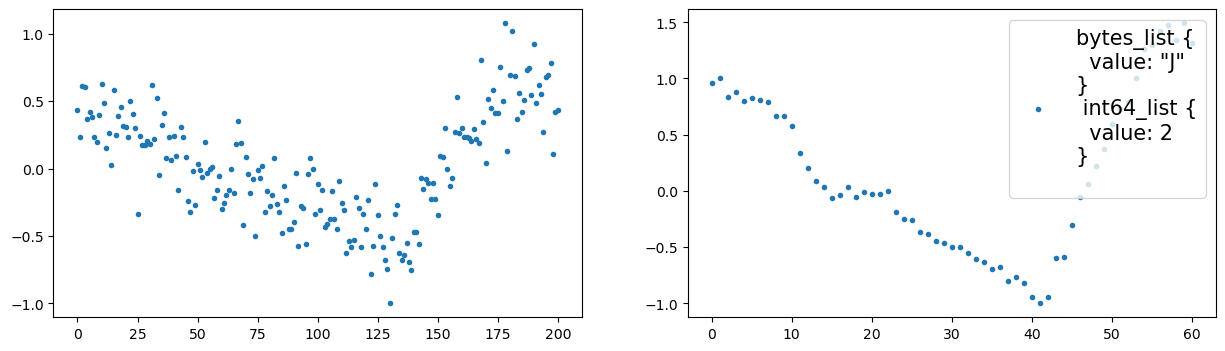

In [6]:
#Number of cureves to plot
n=3
tess_data = tf.data.TFRecordDataset(r'TESS_lightcurves_train/train-00000-of-00008')
for i,sample in enumerate(tess_data.take(n)):
    tess_sample = tf.train.Example()
    tess_sample.ParseFromString(sample.numpy())
    global_view_sample = np.array(tess_sample.features.feature["global_view"].float_list.value)
    local_view_sample = np.array(tess_sample.features.feature["local_view"].float_list.value)
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(global_view_sample, ".")
    ax[1].plot(local_view_sample, ".", label=str(tess_sample.features.feature['Disposition'])+' '+str(tess_sample.features.feature['Sectors']))
    plt.legend(loc='upper right', fontsize=15)

# Known tci_id value

In [7]:
def find_tce(tic_id,all_tess_files):
    for filename in all_tess_files:
        for sample in tf.compat.v1.io.tf_record_iterator(filename):
            tess_sample = tf.train.Example.FromString(sample)
            if (tess_sample.features.feature["tic_id"].int64_list.value[0] == int(tic_id)):
                print("Found {} in files".format(tic_id))
                return tess_sample
        
    raise ValueError("{} not found in any file".format(tic_id))

In [8]:
cwd = os.getcwd()
tess_data_dir=os.path.join(cwd,'TESS_lightcurves_train')
all_tess_files = [os.path.join(tess_data_dir, f) for f in os.listdir(tess_data_dir) if os.path.isfile(os.path.join(tess_data_dir, f))]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Found 261136679 in files


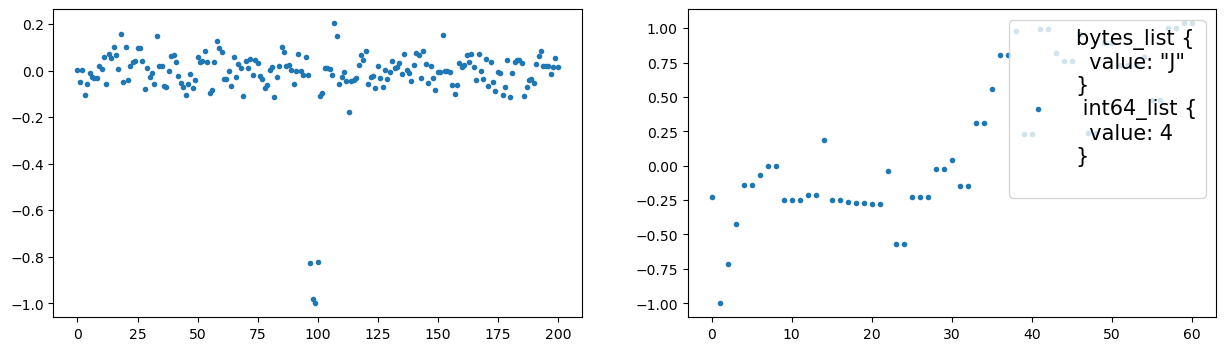

In [9]:
#TIC ID value for bright target Pi Mensae, around which the mission team recently discovered a short period planet candidate on a 6.27 day orbit.
tic_id=261136679
tess_sample=find_tce(tic_id,all_tess_files)
plot_tce_tess(tess_sample)

In [10]:
tess_data = tf.data.TFRecordDataset(r'TESS_lightcurves_train/train-00000-of-00008')
for sample in (tess_data.take(1)):
    tess_sample = tf.train.Example()
    tess_sample.ParseFromString(sample.numpy())
    print(tess_sample)

features {
  feature {
    key: "Disposition"
    value {
      bytes_list {
        value: "J"
      }
    }
  }
  feature {
    key: "Duration"
    value {
      float_list {
        value: 0.018976161
      }
    }
  }
  feature {
    key: "Epoc"
    value {
      float_list {
        value: 1325.5192
      }
    }
  }
  feature {
    key: "Period"
    value {
      float_list {
        value: 0.117514
      }
    }
  }
  feature {
    key: "Qingress"
    value {
      float_list {
        value: 0.04758
      }
    }
  }
  feature {
    key: "SN"
    value {
      float_list {
        value: 17.46343
      }
    }
  }
  feature {
    key: "Sectors"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "Tmag"
    value {
      float_list {
        value: -3.9442065
      }
    }
  }
  feature {
    key: "Transit_Depth"
    value {
      float_list {
        value: -51882.87
      }
    }
  }
  feature {
    key: "camera"
    value {
      int64_list 

In [20]:
#https://ruddra.com/tfrecoaggrds-pandas/

import pandas as pd

for files in [train_tess_files,test_tess_files,val_tess_files]:
    random_dataset=get_dataset(files,None,None)
    df = pd.DataFrame(random_dataset.as_numpy_iterator(),
        columns=['global_view','local_view', 'Disposition'],
    )
    print(df.shape)
    # Percentage of potential planet candidates in 
    print((sum(df['Disposition'])/df.shape[0]*100))

(13188, 3)
16.24203821656051
(3240, 3)
17.191358024691358
(1657, 3)
13.699456849728426


In [12]:
label_map={
              "PC": 1,  # Planet Candidate.
              "EB": 1,
              "J": 0,  # "Junk"
              "V": 0,  # Variable star
              "IS": 0, # Instrumental noise
              "O": 0, # Other
          }
    
#look-up table for mapping the labels as shown above
table_initializer = tf.lookup.KeyValueTensorInitializer(
    keys=list(label_map.keys()),values=list(label_map.values()),
    key_dtype=tf.string,
    value_dtype=tf.int32)
label_to_id = tf.lookup.StaticHashTable(
    table_initializer, default_value=-1)

In [13]:
def parse_element(element):
    
    #output={}*
    data = {
      'Disposition': tf.io.FixedLenFeature([], tf.string),
      'global_view':tf.io.FixedLenFeature([201], tf.float32),
      'local_view':tf.io.FixedLenFeature([61], tf.float32)
    }
    content = tf.io.parse_single_example(element, data)
    
    label= content['Disposition']
    global_view = content['global_view']
    local_view=content['local_view']
    
    for feature_name, value in content.items():
        if feature_name=='Disposition':
            label_id = label_to_id.lookup(value)
            
    #global_view=tf.expand_dims(global_view,axis=-1)
    #label_id=tf.expand_dims(label_id,axis=-1)
     
    
    #label_id = label_to_id.lookup(value)
    return global_view, local_view,label_id

In [14]:
def get_dataset(files,batch_size,data_type):
    
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable native order, increase speed
    

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.with_options(
        ignore_order
    )

    #pass every single feature through our mapping function
    dataset = dataset.map(
        parse_element
    )
    
#     if data_type=='train':
#         dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
#         dataset = dataset.batch(batch_size)
#         dataset = dataset.prefetch(buffer_size=AUTOTUNE)

        #dataset = dataset.repeat()
    
    return dataset

In [15]:
def data_preprocessing(dataset):
    df = pd.DataFrame(dataset.as_numpy_iterator(),
            columns=['global_view','local_view', 'Disposition'],
        )
    l=[]
    for i in range(df.shape[0]):
        l.append(df['global_view'][i])  
    qqq=np.array(l)
    qqq=qqq[:,:,np.newaxis]
    l=[]
    for i in range(df.shape[0]):
        l.append(df['local_view'][i])  
    qqq2=np.array(l)
    qqq2=qqq2[:,:,np.newaxis]
    return qqq,qqq2, df['Disposition']

In [16]:
cwd = os.getcwd()
#Train data
tess_data_dir=os.path.join(cwd,'TESS_lightcurves_train')
train_tess_files = [os.path.join(tess_data_dir, f) for f in os.listdir(tess_data_dir) if os.path.isfile(os.path.join(tess_data_dir, f))]
batch_size=32
train_dataset=get_dataset(train_tess_files,batch_size,'train')

In [17]:
#Train dataset
train_global_inputs, train_local_inputs,train_outputs=data_preprocessing(train_dataset)

In [18]:
#Validation data
val_tess_data_dir=os.path.join(cwd,'TESS_lightcurves_val')
val_tess_files = [os.path.join(val_tess_data_dir, f) for f in os.listdir(val_tess_data_dir) if os.path.isfile(os.path.join(val_tess_data_dir, f))]
val_dataset=get_dataset(val_tess_files,batch_size,'val')
val_global_inputs,val_local_inputs, val_outputs=data_preprocessing(val_dataset)

In [19]:
test_tess_data_dir=r'C:\Users\pavan\OneDrive\Desktop\Final project\TESS_lightcurves_test'
test_tess_files = [os.path.join(test_tess_data_dir, f) for f in os.listdir(test_tess_data_dir) if os.path.isfile(os.path.join(test_tess_data_dir, f))]
test_dataset=get_dataset(test_tess_files,None,'test')
test_global_inputs,test_local_inputs, test_outputs=data_preprocessing(test_dataset)

# CNN model- only global view

In [21]:
# Creating a CNN model, where inputs as only global view values -length of 201
def model_CNN_global_view():
    model = tf.keras.Sequential([

        tf.keras.layers.Conv1D(kernel_size=5, filters=16,padding='same', activation='relu',input_shape=[201,1]),
        tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=5,strides=2),

        tf.keras.layers.Conv1D(kernel_size=5, filters=32,padding='same', activation='relu'),
        tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=5,strides=2),

        tf.keras.layers.Conv1D(kernel_size=5, filters=64,padding='same', activation='relu'),
        tf.keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=7,strides=2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
        
      ])
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
    model.summary()
    return model

In [22]:
global_model=model_CNN_global_view()
global_model.input_shape

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 201, 16)           96        
                                                                 
 conv1d_1 (Conv1D)           (None, 201, 16)           1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 16)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 99, 32)            2592      
                                                                 
 conv1d_3 (Conv1D)           (None, 99, 32)            5152      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 48, 32)           0         
 1D)                                                    

(None, 201, 1)

In [23]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

model_history=global_model.fit(train_global_inputs,train_outputs,validation_data=(val_global_inputs,val_outputs), epochs=20,
                       callbacks=[reduce_lr,earlyStopping])

Epoch 1/20
413/413 [==============================] - 52s 120ms/step - loss: 0.2377 - recall: 0.5789 - precision: 0.7329 - val_loss: 0.1637 - val_recall: 0.7401 - val_precision: 0.7636 - lr: 1.0000e-04
Epoch 2/20
413/413 [==============================] - 47s 114ms/step - loss: 0.1661 - recall: 0.7386 - precision: 0.8035 - val_loss: 0.1583 - val_recall: 0.6388 - val_precision: 0.8631 - lr: 1.0000e-04
Epoch 3/20
413/413 [==============================] - 46s 112ms/step - loss: 0.1522 - recall: 0.7582 - precision: 0.8363 - val_loss: 0.1358 - val_recall: 0.8062 - val_precision: 0.8062 - lr: 1.0000e-04
Epoch 4/20
413/413 [==============================] - 49s 118ms/step - loss: 0.1406 - recall: 0.7899 - precision: 0.8520 - val_loss: 0.1243 - val_recall: 0.8106 - val_precision: 0.8142 - lr: 1.0000e-04
Epoch 5/20
413/413 [==============================] - 48s 117ms/step - loss: 0.1300 - recall: 0.8133 - precision: 0.8569 - val_loss: 0.1130 - val_recall: 0.8018 - val_precision: 0.8505 - lr: 1

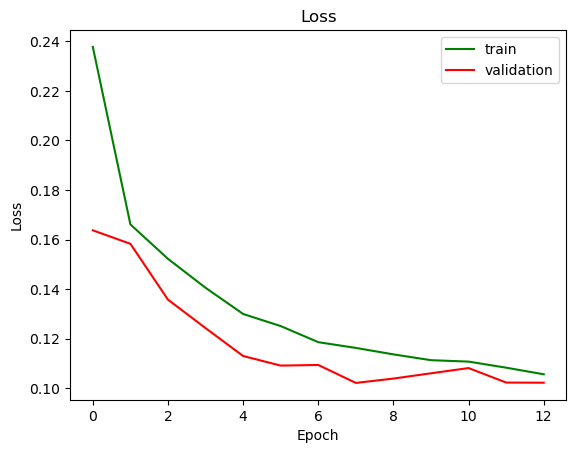

In [24]:
plt.figure()
plt.plot(model_history.history['loss'],'g', label='train')
plt.plot(model_history.history['val_loss'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss', loc='center')
plt.legend()

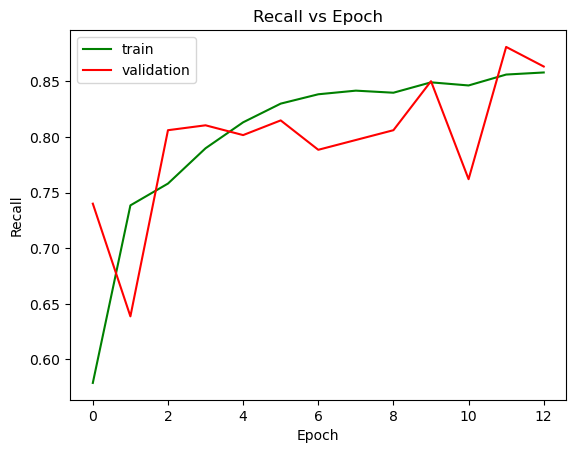

In [25]:
plt.figure()
plt.plot(model_history.history['recall'],'g', label='train')
plt.plot(model_history.history['val_recall'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall vs Epoch', loc='center')
plt.legend()

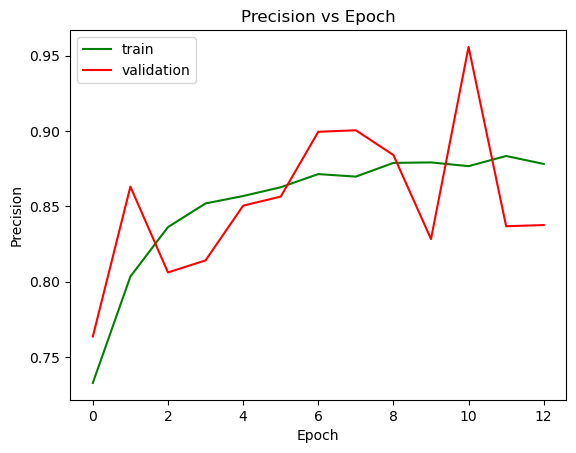

In [26]:
plt.figure()
plt.plot(model_history.history['precision'],'g', label='train')
plt.plot(model_history.history['val_precision'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision vs Epoch', loc='center')
plt.legend()

# Test data Predict

In [27]:
res=global_model.predict(test_global_inputs)
roc_auc_score(test_outputs,res)

102/102 [==============================] - 1s 3ms/step


0.9804346938734542

In [28]:
res=np.round(res)
cf=confusion_matrix(test_outputs,res)
cf

array([[2620,   63],
       [  77,  480]], dtype=int64)

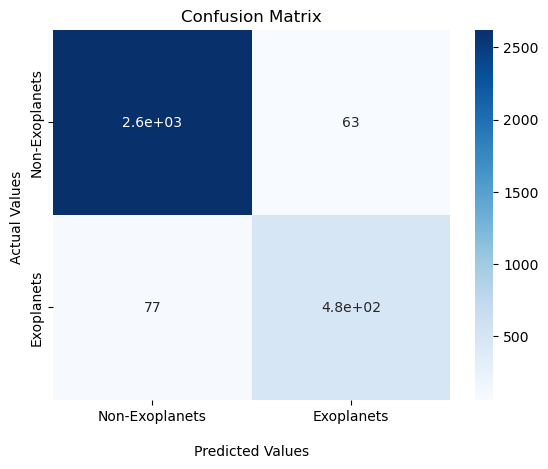

In [29]:
import seaborn as sns

ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non-Exoplanets','Exoplanets'])
ax.yaxis.set_ticklabels(['Non-Exoplanets','Exoplanets'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [30]:
precision_score(test_outputs,res)

0.8839779005524862

In [31]:
recall_score(test_outputs,res)

0.8617594254937163

In [32]:
precision_recall_curve(test_outputs,res)

(array([0.17191358, 0.8839779 , 1.        ]),
 array([1.        , 0.86175943, 0.        ]),
 array([0., 1.], dtype=float32))

In [33]:
print("F1 score for CNN using only global views on test data=",f1_score(test_outputs,res))

F1 score for CNN using only global views on test data= 0.8727272727272727


In [34]:
pd.DataFrame(classification_report(test_outputs, res, output_dict=True)).T

,precision,recall,f1-score,support
0,0.971450,0.976519,0.973978,2683.00000
1,0.883978,0.861759,0.872727,557.00000
accuracy,0.956790,0.956790,0.956790,0.95679
macro avg,0.927714,0.919139,0.923352,3240.00000
weighted avg,0.956412,0.956790,0.956571,3240.00000


# Only Local View

In [135]:
# Creating a CNN model, where inputs as only Local view values -length of 201
def model_CNN_local_view():
    model = tf.keras.Sequential([

        tf.keras.layers.Conv1D(kernel_size=5, filters=16,padding='same', activation='relu',input_shape=[61,1]),
        tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=5,strides=2),

        tf.keras.layers.Conv1D(kernel_size=5, filters=32,padding='same', activation='relu'),
        tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=5,strides=2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation='sigmoid'),
      ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
    model.summary()
    return model

In [136]:
model_local=model_CNN_local_view()
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')

model_history=model_local.fit(train_local_inputs,train_outputs,validation_data=(val_local_inputs,val_outputs), batch_size=32,epochs=30,
                       callbacks=[reduce_lr,earlyStopping])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 61, 16)            96        
                                                                 
 conv1d_19 (Conv1D)          (None, 61, 16)            1296      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 29, 16)           0         
 1D)                                                             
                                                                 
 conv1d_20 (Conv1D)          (None, 29, 32)            2592      
                                                                 
 conv1d_21 (Conv1D)          (None, 29, 32)            5152      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 13, 32)           0         
 g1D)                                                 

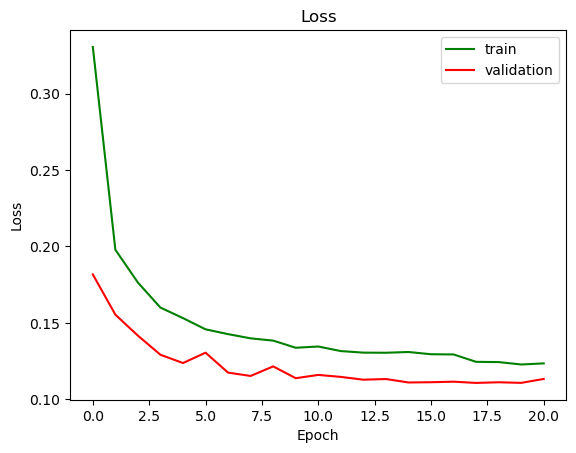

In [119]:
plt.figure()
plt.plot(model_history.history['loss'],'g', label='train')
plt.plot(model_history.history['val_loss'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss', loc='center')
plt.legend()

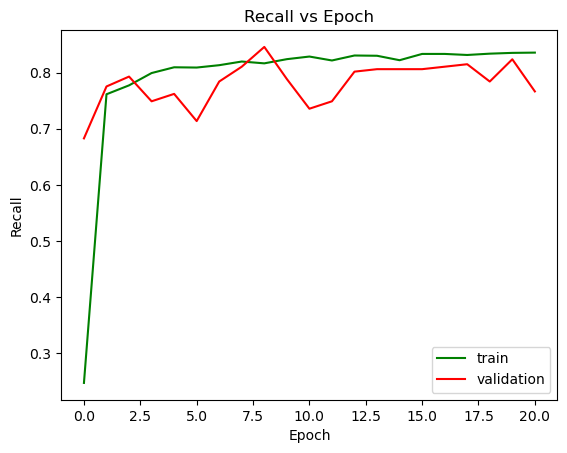

In [120]:
plt.figure()
plt.plot(model_history.history['recall_13'],'g', label='train')
plt.plot(model_history.history['val_recall_13'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall vs Epoch', loc='center')
plt.legend()

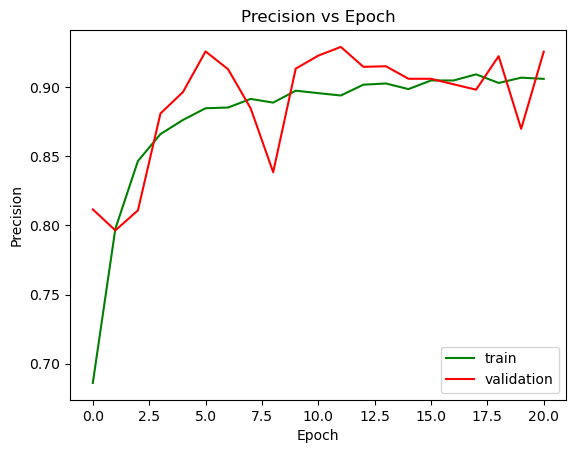

In [121]:
plt.figure()
plt.plot(model_history.history['precision_13'],'g', label='train')
plt.plot(model_history.history['val_precision_13'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision vs Epoch', loc='center')
plt.legend()

# Test data Predict

In [123]:
res=model_local.predict(test_local_inputs)
roc_auc_score(test_outputs,res)

102/102 [==============================] - 0s 2ms/step


0.9785135613487677

In [124]:
res=np.round(res)
cf=confusion_matrix(test_outputs,res)

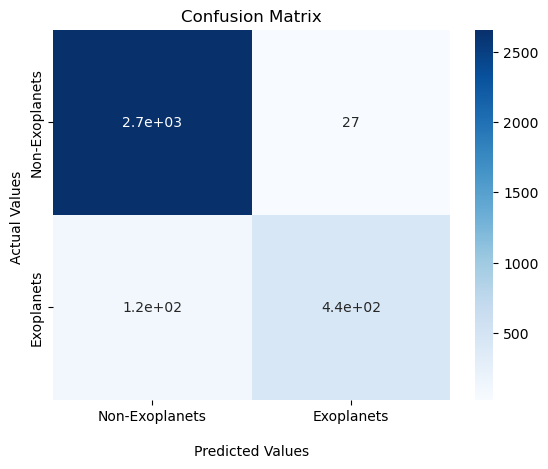

In [125]:
import seaborn as sns

ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non-Exoplanets','Exoplanets'])
ax.yaxis.set_ticklabels(['Non-Exoplanets','Exoplanets'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [43]:
precision_score(test_outputs,res)

0.9560439560439561

In [44]:
recall_score(test_outputs,res)

0.7809694793536804

In [45]:
precision_recall_curve(test_outputs,res)

(array([0.17191358, 0.95604396, 1.        ]),
 array([1.        , 0.78096948, 0.        ]),
 array([0., 1.], dtype=float32))

In [46]:
print("F1 score for CNN using only global views on test data=",f1_score(test_outputs,res))

F1 score for CNN using only global views on test data= 0.8596837944664032


In [47]:
pd.DataFrame(classification_report(test_outputs, res, output_dict=True)).T

,precision,recall,f1-score,support
0,0.956194,0.992546,0.974031,2683.000000
1,0.956044,0.780969,0.859684,557.000000
accuracy,0.956173,0.956173,0.956173,0.956173
macro avg,0.956119,0.886758,0.916857,3240.000000
weighted avg,0.956168,0.956173,0.954373,3240.000000


# Fully connected layers

In [130]:
from keras.models import Model

global_fully_model_inp=tf.keras.layers.Input(shape=(201,))
global_fully_model=tf.keras.layers.Dense(128,activation='relu',name='global_frst')(global_fully_model_inp)
global_fully_model=tf.keras.layers.Dropout(0.2)(global_fully_model)
global_fully_model=tf.keras.layers.Dense(64,activation='relu')(global_fully_model)
global_fully_model=tf.keras.layers.Dropout(0.2)(global_fully_model)

local_fully_model_inp=tf.keras.Input(shape=(61,))
local_fully_model=tf.keras.layers.Dense(64,activation='relu',name='local_frst')(local_fully_model_inp)
local_fully_model=tf.keras.layers.Dropout(0.2)(local_fully_model)

concat=concatenate([global_fully_model,local_fully_model],axis=1,name='concat_layer')
final_model=(tf.keras.layers.Dense(32,activation='relu'))(concat)
final_model=(tf.keras.layers.Dense(1,activation='sigmoid'))(final_model)

final_merged_model=Model(inputs=[(global_fully_model_inp,local_fully_model_inp)],outputs=[final_model])

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
final_merged_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
final_merged_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 201)]        0           []                               
                                                                                                  
 global_frst (Dense)            (None, 128)          25856       ['input_20[0][0]']               
                                                                                                  
 dropout_38 (Dropout)           (None, 128)          0           ['global_frst[0][0]']            
                                                                                                  
 input_21 (InputLayer)          [(None, 61)]         0           []                               
                                                                                            

In [132]:
model_history=final_merged_model.fit([train_global_inputs,train_local_inputs],train_outputs,validation_data=([val_global_inputs,val_local_inputs],val_outputs)
                                     , batch_size=32, epochs=1, callbacks=[reduce_lr,earlyStopping])

413/413 [==============================] - 1s 3ms/step - loss: 0.1828 - recall_12: 0.7003 - precision_12: 0.9305 - val_loss: 0.1411 - val_recall_12: 0.7974 - val_precision_12: 0.8829 - lr: 1.0000e-04


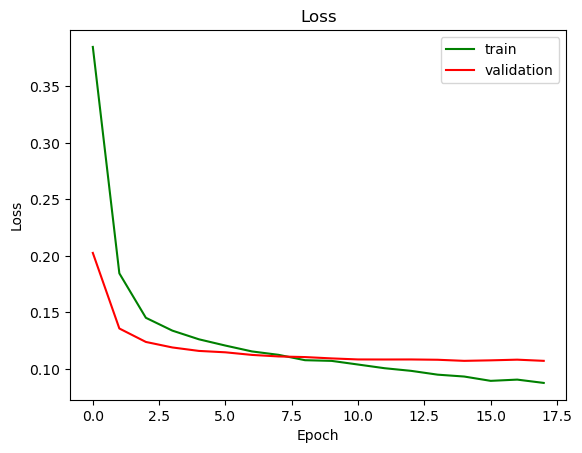

In [50]:
plt.figure()
plt.plot(model_history.history['loss'],'g', label='train')
plt.plot(model_history.history['val_loss'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss', loc='center')
plt.legend()

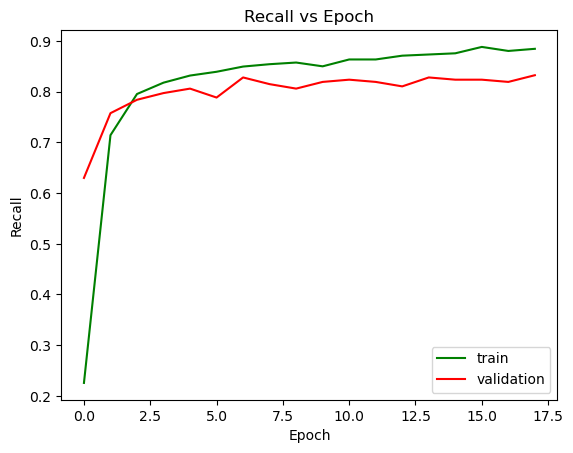

In [52]:
plt.figure()
plt.plot(model_history.history['recall_2'],'g', label='train')
plt.plot(model_history.history['val_recall_2'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall vs Epoch', loc='center')
plt.legend()

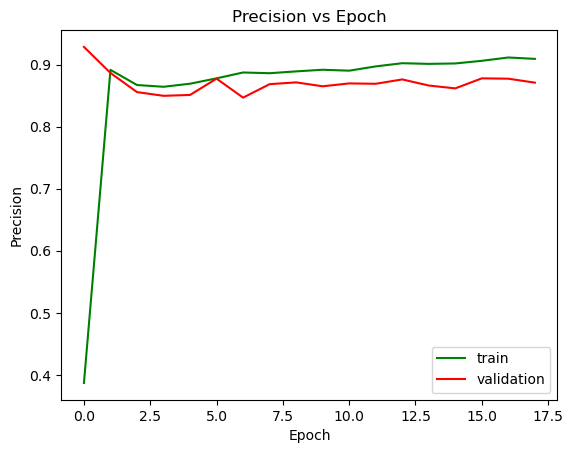

In [53]:
plt.figure()
plt.plot(model_history.history['precision_2'],'g', label='train')
plt.plot(model_history.history['val_precision_2'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision vs Epoch', loc='center')
plt.legend()

# Test data Predict

In [54]:
res=final_merged_model.predict([test_global_inputs,test_local_inputs])
roc_auc_score(test_outputs,res)

102/102 [==============================] - 0s 1ms/step


0.9821075713766643

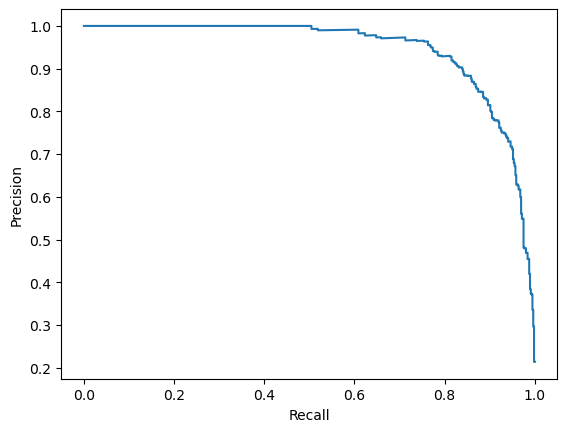

In [55]:
precision,recall,thr=precision_recall_curve(test_outputs,res)
plt.plot(recall,precision)
plt.xlabel("Recall")
plt.ylabel("Precision");

In [56]:
res=np.round(res)
cf=confusion_matrix(test_outputs,res)
cf

array([[2639,   44],
       [  97,  460]], dtype=int64)

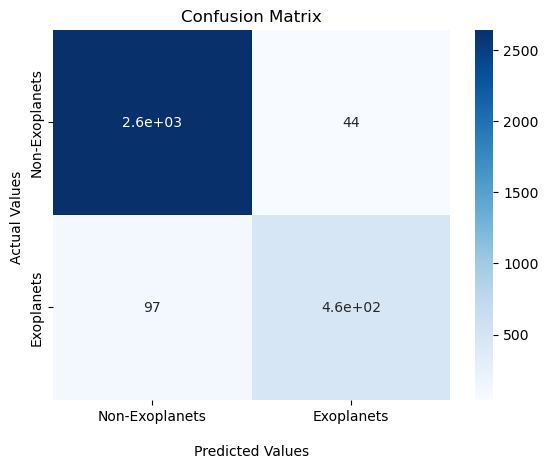

In [57]:
import seaborn as sns

ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non-Exoplanets','Exoplanets'])
ax.yaxis.set_ticklabels(['Non-Exoplanets','Exoplanets'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [58]:
precision_score(test_outputs,res)

0.9126984126984127

In [59]:
recall_score(test_outputs,res)

0.8258527827648114

In [60]:
accuracy_score(test_outputs,res)

0.9564814814814815

In [61]:
print("F1 score for CNN using only global views on test data=",f1_score(test_outputs,res))

F1 score for CNN using only global views on test data= 0.8671065032987748


In [62]:
pd.DataFrame(classification_report(test_outputs, res, output_dict=True)).T

,precision,recall,f1-score,support
0,0.964547,0.983600,0.973980,2683.000000
1,0.912698,0.825853,0.867107,557.000000
accuracy,0.956481,0.956481,0.956481,0.956481
macro avg,0.938623,0.904727,0.920543,3240.000000
weighted avg,0.955633,0.956481,0.955607,3240.000000


# LSTM model

In [110]:
from keras.models import Model

global_fully_model_inp=tf.keras.layers.Input(shape=(201,1))
global_fully_model=tf.keras.layers.LSTM(128,activation='tanh',return_sequences=True)(global_fully_model_inp)
global_fully_model=tf.keras.layers.Dropout(0.2)(global_fully_model)
global_fully_model=tf.keras.layers.LSTM(64,activation='tanh')(global_fully_model)
global_fully_model=tf.keras.layers.Dropout(0.2)(global_fully_model)

local_fully_model_inp=tf.keras.Input(shape=(61,1))
local_fully_model=tf.keras.layers.LSTM(64,activation='tanh')(local_fully_model_inp)
local_fully_model=tf.keras.layers.Dropout(0.2)(local_fully_model)

concat=concatenate([global_fully_model,local_fully_model],axis=1,name='concat_layer')
final_model=(tf.keras.layers.Dense(32,activation='relu'))(concat)
final_model=(tf.keras.layers.Dense(1,activation='sigmoid'))(final_model)

final_merged_model=Model(inputs=[(global_fully_model_inp,local_fully_model_inp)],outputs=[final_model])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
final_merged_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
final_merged_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 201, 1)]     0           []                               
                                                                                                  
 lstm_22 (LSTM)                 (None, 201, 128)     66560       ['input_14[0][0]']               
                                                                                                  
 dropout_27 (Dropout)           (None, 201, 128)     0           ['lstm_22[0][0]']                
                                                                                                  
 input_15 (InputLayer)          [(None, 61, 1)]      0           []                               
                                                                                            

In [111]:
model_history=final_merged_model.fit([train_global_inputs,train_local_inputs],train_outputs,validation_data=([val_global_inputs,val_local_inputs],val_outputs), 
                                     batch_size=32, epochs=20, callbacks=[reduce_lr,earlyStopping])

Epoch 1/20
413/413 [==============================] - 103s 224ms/step - loss: 0.2878 - recall_8: 0.5023 - precision_8: 0.6915 - val_loss: 0.2168 - val_recall_8: 0.6211 - val_precision_8: 0.7382 - lr: 5.0000e-04
Epoch 2/20
413/413 [==============================] - 109s 264ms/step - loss: 0.2246 - recall_8: 0.7171 - precision_8: 0.7427 - val_loss: 0.2045 - val_recall_8: 0.5771 - val_precision_8: 0.8037 - lr: 5.0000e-04
Epoch 3/20
413/413 [==============================] - 112s 271ms/step - loss: 0.2029 - recall_8: 0.7386 - precision_8: 0.7867 - val_loss: 0.1640 - val_recall_8: 0.7401 - val_precision_8: 0.8000 - lr: 5.0000e-04
Epoch 4/20
413/413 [==============================] - 113s 273ms/step - loss: 0.1861 - recall_8: 0.7684 - precision_8: 0.7959 - val_loss: 0.1560 - val_recall_8: 0.7533 - val_precision_8: 0.8143 - lr: 5.0000e-04
Epoch 5/20
413/413 [==============================] - 128s 310ms/step - loss: 0.1773 - recall_8: 0.7708 - precision_8: 0.8267 - val_loss: 0.1567 - val_recal

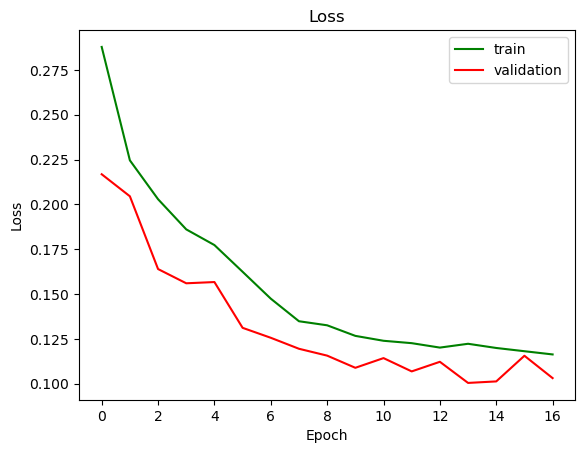

In [112]:
plt.figure()
plt.plot(model_history.history['loss'],'g', label='train')
plt.plot(model_history.history['val_loss'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss', loc='center')
plt.legend()

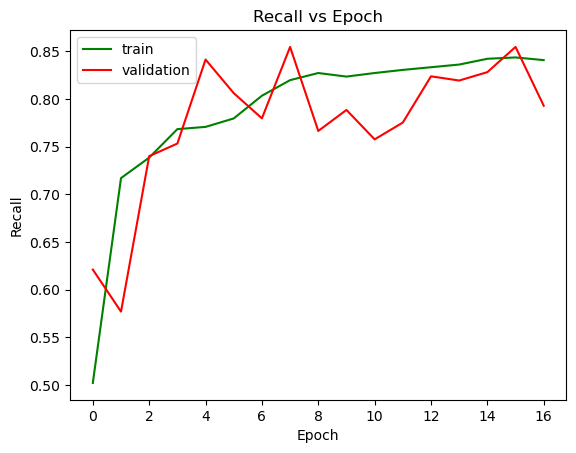

In [113]:
plt.figure()
plt.plot(model_history.history['recall_8'],'g', label='train')
plt.plot(model_history.history['val_recall_8'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall vs Epoch', loc='center')
plt.legend()

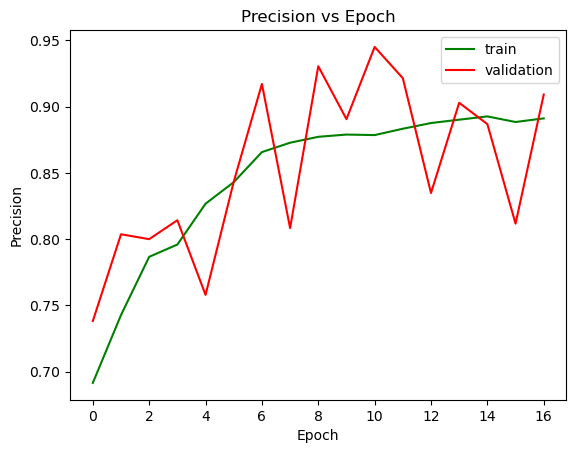

In [114]:
plt.figure()
plt.plot(model_history.history['precision_8'],'g', label='train')
plt.plot(model_history.history['val_precision_8'],'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision vs Epoch', loc='center')
plt.legend()

# Test data Predict

In [102]:
res=final_merged_model.predict([test_global_inputs,test_local_inputs])
roc_auc_score(test_outputs,res)

102/102 [==============================] - 18s 109ms/step


0.9759580736748635

In [103]:
res=np.round(res)
cf=confusion_matrix(test_outputs,res)

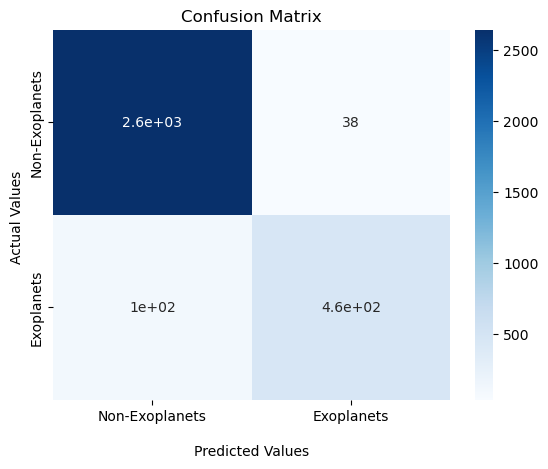

In [104]:
import seaborn as sns

ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non-Exoplanets','Exoplanets'])
ax.yaxis.set_ticklabels(['Non-Exoplanets','Exoplanets'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [105]:
precision_score(test_outputs,res)

0.9232323232323232

In [106]:
recall_score(test_outputs,res)

0.8204667863554758

In [107]:
precision_recall_curve(test_outputs,res)

(array([0.17191358, 0.92323232, 1.        ]),
 array([1.        , 0.82046679, 0.        ]),
 array([0., 1.], dtype=float32))

In [108]:
print("F1 score for CNN using only global views on test data=",f1_score(test_outputs,res))

F1 score for CNN using only global views on test data= 0.8688212927756654


In [109]:
pd.DataFrame(classification_report(test_outputs, res, output_dict=True)).T

,precision,recall,f1-score,support
0,0.963570,0.985837,0.974576,2683.000000
1,0.923232,0.820467,0.868821,557.000000
accuracy,0.957407,0.957407,0.957407,0.957407
macro avg,0.943401,0.903152,0.921699,3240.000000
weighted avg,0.956636,0.957407,0.956396,3240.000000
